# Example Notebook #3 - ML Portfolio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import talib
import seaborn as sns
from portfolio_swissknife import portfolio as ps
from portfolio_swissknife import models as mod

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

## 1. Load Data and Features

In [2]:
#load data
opn = pd.read_csv('../ext_data/00_db_SPX__PX_OPEN.csv',index_col=0, parse_dates=True)
opn.columns = opn.columns.map(lambda x:x.split(' ')[0])
opn = opn[::-1] #ascending dates
opn = opn.loc[:,~opn.columns.duplicated()]

high = pd.read_csv('../ext_data/00_db_SPX__PX_HIGH.csv',index_col=0, parse_dates=True)
high.columns = high.columns.map(lambda x:x.split(' ')[0])
high = high[::-1]
high = high.loc[:,~high.columns.duplicated()]

low = pd.read_csv('../ext_data/00_db_SPX__PX_LOW.csv',index_col=0, parse_dates=True)
low.columns = low.columns.map(lambda x:x.split(' ')[0])
low = low[::-1]
low = low.loc[:,~low.columns.duplicated()]


close = pd.read_csv('../ext_data/00_db_SPX__PX_LAST.csv',index_col=0, parse_dates=True)
close.columns = close.columns.map(lambda x:x.split(' ')[0])
close = close[::-1] 
close = close.loc[:,~close.columns.duplicated()]

volume = pd.read_csv('../ext_data/00_db_SPX__PX_VOLUME.csv',index_col=0, parse_dates=True)
volume.columns = volume.columns.map(lambda x:x.split(' ')[0])
volume = volume[::-1]
volume = volume.loc[:,~volume.columns.duplicated()]

macro = pd.read_excel('../ext_data/macro.xlsx',sheet_name = 'data', index_col = 0, parse_dates = True)
macro = macro.loc[close['AAPL'].index[0]:close['AAPL'].index[-1]] #reindex

with open('../ext_data/features.pkl', 'rb') as handle:
    fund = pickle.load(handle)

In [3]:
#loading ext. data -- close prices of SPX
universe = pd.read_csv('../ext_data/00_db_SPX__PX_LAST.csv', index_col = 0, parse_dates = True)
universe = universe[::-1].loc[:,universe.notna().all(axis=0)]
securities = [universe.columns[i].split(' ')[0] for i, _ in enumerate(universe.columns)]
universe.columns = securities
missing = ['BF/B','BRK/B','CXO','ETN','LB','VAR','UAL']
universe = universe.drop(missing, axis = 1)
securities = [elem for elem in securities if elem not in missing]

## 2. Constructing ML Portfolio

### 2a. Create Portfolio universe and Prediction Model objects

In [4]:
port_universe = ps.Portfolio(securities)
port_universe.set_custom_prices(universe, 'daily')

In [5]:
pred_model = mod.PredictionModel(port_universe)
pred_model.set_features(macro.to_period('M')) #add macro features
pred_model.set_features({sec : fund[sec].to_period('M') for 
                         sec in fund.keys()}) #add fundamental features
pred_model.prepare_targets(macro)

### 2b. Define a Training Episode

In [6]:
def rf_training_episode(y, X):
    #labeling
    y = y.apply(lambda x: 1 if x >= 0.02 else 0)
    
    #grid search
    grid = {'n_estimators': [200, 500], 'max_depth': [3, 9, 12],
            'max_features': [4, 8, 12], 'random_state': [42]}
    test_scores = []

    rf_model = RandomForestClassifier()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X, y)
        test_scores.append(rf_model.score(X, y))

    best_index = np.argmax(test_scores)
    
    #fitting the optimal model
    rf = RandomForestClassifier(**ParameterGrid(grid)[best_index])
    rf.fit(X, y)
    
    pred_prob_long = rf.predict_proba(X)[-1][1]
    return pred_prob_long

In [7]:
pred_model.set_prediction_model(rf_training_episode)

### 2c. Train the model using a rolling window

In [8]:
# pred_model.rolling_model_prediction(estimation_period=60, window = 1)

In [9]:
# ## save intermediate results
# with open('tree_preds_2.pkl', 'wb') as handle:
#     pickle.dump(pred_model.prediction_measure, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [10]:
with open('tree_preds_1.pkl', 'rb') as handle:
    preds_1 = pickle.load(handle)
with open('tree_preds_2.pkl', 'rb') as handle:
    preds_2 = pickle.load(handle)

In [11]:
pred_model.load_pretrained_model([preds_1, preds_2])

### 2d. Conduct asset selection by sorting 

In [12]:
pred_model.rolling_spread_selection(10, window = 1)

### 2e. Initialize ML Portfolio and backtest the strategy

In [13]:
ml_portfolio_trees = ps.MLPortfolio(port_universe, prediction_model = pred_model)
ml_portfolio_trees.set_constraints(default = True)
ml_portfolio_trees.set_benchmark('SPY')
ml_portfolio_trees.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
ml_portfolio_trees.historical_backtest(long_only = False, long_exposure = 1, short_exposure= 0.3, 
                                       frequency = 22, estimation_period = 5*252)

,EW,GMV,RP
Average Returns,11.94%,5.96%,10.29%
CAGR,11.54%,5.29%,9.97%
Volatility,34.55%,24.41%,32.08%
CEQ,-5.337747,-6.247967,-5.750023
Max DD,34.25%,32.71%,29.60%
Skewness,-0.77,-0.39,-0.55
Kurtosis,-2.99,-2.99,-2.99
Sharpe Ratio,0.28,0.16,0.25
Sortino Ratio,0.80,0.36,0.77
Calmar Ratio,-0.35,-0.18,-0.35


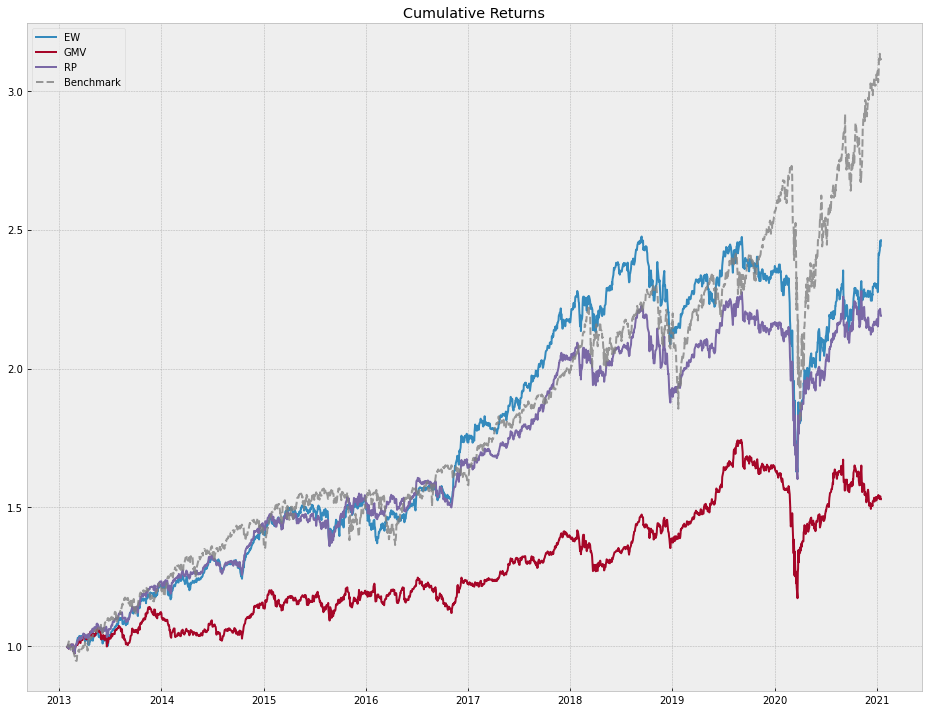

In [15]:
ml_portfolio_trees.get_backtest_report(display_weights=False, num_periods = 252)